# CANARIE 2017 -- Analysis of the survey

This notebook is the first draft to analyse the results from [CANARIE]()

## Loading libraries to work in notebook

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib

# When using Ipython within vim
matplotlib.use('TkAgg')

# When using within jupyter
get_ipython().magic('matplotlib inline')  # Activat that line to use in Jupyter

import matplotlib.pyplot as plt

#  When using this script with ipython and vim
#plt.ion()
#plt.show()

## Preparation and filtering of the dataset

The data are stored in the csv file. It contains 114 answers that need to be filtered to only keep participants that are from Canada, completed the survey and are developing software

In [2]:
# Load dataset
df = pd.read_csv('./dataset/2017 Cdn Research Software Developer Survey - Public data.csv')
# Number of row == number of participants
len(df.index)

114

In [3]:
# ### Date submitted
# The variable 'Date submitted' is set up when the participant finish the survey. If the row on this column is empty, it means the participant did not finish the survey. These participants are removed, even if they have submitted partial answers.

df = df[df['Date submitted'].notnull()]
# Getting the number of row from the reduced dataframe
len(df.index)

102

In [4]:
# Countries
#A question asked the participants in which country they were currently working and specify when it was not Canada.
pd.crosstab(df['In which country do you work?'], columns='Countries')
# There is only 4 others. Which are only one from Japan, 2 from USA and one from UK.
pd.crosstab(df['In which country do you work? [Other]'], columns='Other countries')
# As this answer are not useful for CANARIE, because these people are not working in Canada, they are removed from the dataset.
df = df.loc[df['In which country do you work?'] != 'Other']
# Getting the number of row from the reduced dataframe
len(df.index)

99

In [5]:
# ### Writing software as part of the work
#
# One question asked if the participants write software for research as part of their work.
pd.crosstab(df['Do you write software for research as part of your job?'], columns='Writing software')
# 13 answered 'No'. This survey, being about researcher that write codes, they are removed from the dataset
df = df.loc[df['Do you write software for research as part of your job?'] == 'Yes']
# Getting the number of row from the reduced dataframe
len(df.index)

90

A bit of cleaning, all answer "Prefer not to answer" are replace with a NaN value. They are not giving any information and were present to offer the possibility to the participants to select that option. 

In [6]:
# Replacing all the answer "Prefer not to answer" by NaN, as they are not useful in the analysis
df.replace('Prefer not to answer', np.NaN, inplace=True)

# Some columns have a unbreakable space in their name, replace it
df.columns = df.columns.str.replace('\xa0', '')


# Functions
Some functions have been created to facilitated the exploration of the question and the visualisations of the answers. They are all regrouped here under sections. 
These different sections reflects the process of exploration (analysing the different questions by their type of answer rather than the chronological order that the participants had to follow). 


In [7]:
def explore_other(colname, printUnique=False):
    """
    To output the unique value of the column
    and the column '[Other]' associated with it
    :params:
        :colnames str(): string to match the column
    :return: None
    """
    col_other = colname + ' [Other]'
    if printUnique is True:
        print('Unique values in the normal column')
        print(df[colname].unique())
        print('Unique values in the other columns')
        print(df[col_other].unique())
    return colname

In [8]:
def recode_values(x, replacement_values, default=False):
    """
    Function to use with an  apply on a Serie to replace values if they match
    the values from the dictionary passed into the argument.
    :params:
        :replacement_values dict(): K are the content to match and values the content
        to replace with
        :default: if a value is given to default, this value will be return, if it is
        false, the passed value is returned instead
    :return:
        :x: the x is returned or the replacement values if found in the dictionary or the
        default if not None.
    """
    if not pd.isnull(x):
        for k in replacement_values:
            if str(k).lower() in str(x).lower():
                return replacement_values[k]
        if default:
            return default
    return x

In [9]:
def merging_others(df, colname, replacement_values=None):
    """
    Function to wrap the different modification applied on
    the columns that have a `other` column associated.
    Only search if some others could be merged with the prexisting answers
    and merge it to into the original column, then transform the column into
    categorical variable
    :params:
        :df pd.df(): dataframe containing the data
        :colname str(): string that have the column header to select the right column
        :replacement_values dict(): contain which value to match in the column 'other' as
        the key and which value to replace with. If it is None, skip the transformation (Default)
    :return:
        :None: The operation is a replace `inplace`
    """
    colname_other = var+ ' [Other]'
    if replacement_values:
        df[colname_other] = df[colname_other].apply(recode_values, args=(replacement_values, 'Other'))
        df[colname].replace('Other', df[colname_other], inplace=True)

    df[colname] = df[colname].str.capitalize().astype('category')

In [10]:
def freq_table(df, colnames=False, columns='count', add_ratio=False, sort_order=False):
    """
    """
    if add_ratio:
        output = pd.concat([pd.crosstab(df[colnames], columns='count', normalize=False),
          pd.crosstab(df[colnames], columns='ratio', normalize=True)], axis=1)
    else:
        output = pd.crosstab(df[colnames], colnames=[''], columns=columns)
    if sort_order:
        output = output.sort_values(by='count')
    return output

In [11]:
def freq_plotting(df, colnames='count', sort_order=False, stacked=False, horizontal=False):
    """
    Plot the others variables
    :params:
        :df pd.df(): dataframe containing the data, should be a df of frequencies
        created with crosstab
        :colname str(): string that have the column header to select the right column
    """
    type_plot = 'bar'
    # Call the freq_table function to create the count to plot
    # d = freq_table(df, colnames, columns)
    if sort_order:
        df = df.sort_values(by=colnames, ascending=False)
    if horizontal is True:
        type_plot='barh'

    df[colnames].plot(kind=type_plot, stacked=stacked)

In [12]:
def save_freq_plotting(df, columns, colnames=False, sort_order=False, stacked=False, horizontal=False):
    """
    Plot the others variables
    :params:
        :df pd.df(): dataframe containing the data
        :colname str(): string that have the column header to select the right column
    """
    type_plot = 'bar'
    if colnames is False:
        colnames = columns
    # Call the freq_table function to create the count to plot
    d = freq_table(df, colnames, columns)
    if sort_order:
        d = d.sort_values(by=colnames, ascending=False)
    if horizontal is True:
        type_plot='barh'
    
    d.plot(kind=type_plot, stacked=stacked)
    return d

In [13]:
## TODO Remove the part of this function that output a freq_table to call freq_table() instead
def count_unique_value(df, colnames, rename_columns=False, dropna=False, normalize=False):
    """
    Count the values of different columns and transpose the count
    :params:
        :df pd.df(): dataframe containing the data
        :colnames list(): list of strings corresponding to the column header to select the right column
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    # Subset the columns
    df_sub = df[colnames]

    if rename_columns is True:
        df_sub.columns = [s.split('[', 1)[1].split(']')[0] for s in colnames]

    # Calculate the counts for them
    df_sub = df_sub.apply(pd.Series.value_counts, dropna=dropna, normalize=normalize)
    # Transpose the column to row to be able to plot a stacked bar chart
    return df_sub.transpose()

# Exploration of the results

## Languages

The survey was in French and in English. The option choose by the participant was collected. It is possible then to see the proportion of participants that answered the survey in French or in English

In [14]:
language_count = freq_table(df, 'Start language', add_ratio=True, sort_order=True)

In [15]:
language_count

col_0,count,ratio
Start language,,
fr,11,0.122222
en,79,0.877778


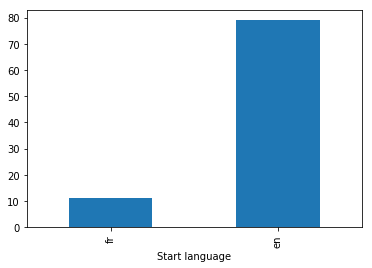

In [16]:
language_count['count'].plot(kind='bar')

## Education level
The question asked the level of education

In [17]:
# Recode the column as categorical variable
df['What is the highest level of education you have attained?'] = df['What is the highest level of education you have attained?'].astype('category')

# Reorder the factors to match the education level
df['What is the highest level of education you have attained?'].cat.reorder_categories(['Some University',
                                                                                        'College Diploma',
                                                                                        'Bachelors Degree',
                                                                                        'Masters Degree',
                                                                                        'Doctorate'],
                                                                                       inplace=True)


In [18]:
education_count = freq_table(df, 'What is the highest level of education you have attained?', add_ratio=True, sort_order=True)

In [19]:
education_count

col_0,count,ratio
What is the highest level of education you have attained?,,
College Diploma,4,0.044444
Some University,5,0.055556
Bachelors Degree,16,0.177778
Masters Degree,25,0.277778
Doctorate,40,0.444444


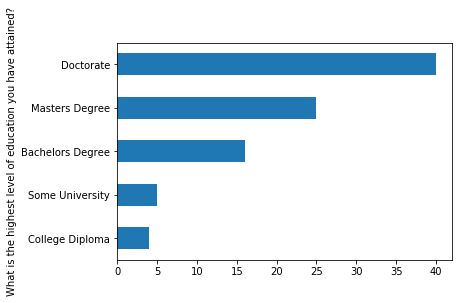

In [20]:
education_count['count'].plot(kind='barh', sort_columns=True)

In [21]:
freq_table(df, 'In which discipline is your highest academic qualification? [Other]', sort_order=True)

,count
In which discipline is your highest academic qualification? [Other],
Biochemistry/Bioinformatics,1
computer,1
Systems,1
Software Engineering,1
Other Engineering,1
Mathematics,1
Master in Software Systems,1
History,1
informatique,1


In [22]:
var = explore_other('In which discipline is your highest academic qualification?')
discipline_values = {'bioinfo': 'Bioinformatics',
                     'computer': 'Information technology',
                     'informatique': 'Information technology',
                     'history': 'Social sciences and humanities',
                     'biophysics': 'Physics',
                     'software': 'Information and communication services',
                     'dance': 'Social Sciences and Humanities',
                     'musique': 'Social Sciences and Humanities',
                     'agric': 'Agricultural engineering'}
merging_others(df, var, discipline_values)
disciplines = freq_table(df, var, add_ratio=True, sort_order=True)


In [23]:
disciplines

col_0,count,ratio
In which discipline is your highest academic qualification?,,
Agricultural engineering,1,0.011111
Industrial engineering,1,0.011111
Hydrology,1,0.011111
Geoghraphical information,1,0.011111
Mechanical engineering,1,0.011111
Fluid mechanics,1,0.011111
Microbiology,1,0.011111
Mining and mineral processing,1,0.011111
Earth science,1,0.011111


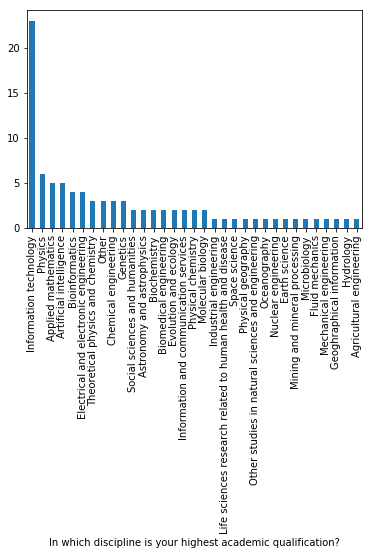

In [24]:
# Now the data is cleaned, it is possible to plot it
freq_plotting(disciplines, sort_order=True)

In [25]:
software_dev_number = freq_table(df, 'How many software developers typically work on your projects?', add_ratio=True)
# Reorganise the row names to match the normal order
software_dev_number = software_dev_number.reindex(['Just me', '2', '3-5',  '6-9', '10+'])


In [26]:
software_dev_number

col_0,count,ratio
How many software developers typically work on your projects?,,
Just me,20,0.224719
2,19,0.213483
3-5,34,0.382022
6-9,10,0.112360
10+,6,0.067416


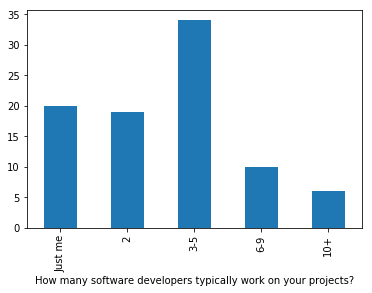

In [27]:
freq_plotting(software_dev_number)

In [28]:
# ## 'How many software projects are you currently involved in?',

# Recategorise the answers into 10 categories


def replace_project(x):

    if pd.isnull(x):
        return
    if x >=1 and x <=3:
        return "1-3"
    elif x >=4 and x <=6:
        return "4-6"
    elif x >=7 and x <=9:
        return "7-9"
    elif x > 10 and x <= 12:
        return "10-12"
    elif x > 13 and x <= 15:
        return "13-15"
    elif x > 16 and x <= 18:
        return "16-18"
    elif x > 19 and x <= 21:
        return "19-21"
    elif x >= 22:
        return ">=22"


df['How many software projects are you currently involved in?[recat]'] = df['How many software projects are you currently involved in?'].apply(replace_project)

software_project = freq_table(df, 'How many software projects are you currently involved in?[recat]', add_ratio=True, sort_order=True)
# Reorganise the row names that contains the categories to plot in the right order
software_project = software_project.reindex(['1-3',
               '4-6',
               '7-9',
               '10-12',
               '13-15',
               '16-18',
               '19-21',
               '>22'])


In [29]:
software_project

col_0,count,ratio
How many software projects are you currently involved in?[recat],,
1-3,47.0,0.573171
4-6,29.0,0.353659
7-9,4.0,0.048780
10-12,NaN,NaN
13-15,NaN,NaN
16-18,NaN,NaN
19-21,1.0,0.012195
>22,NaN,NaN


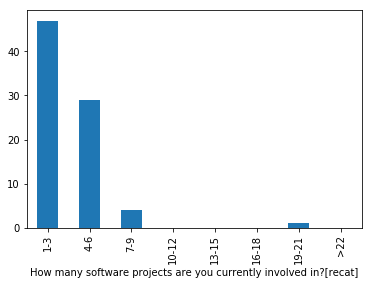

In [30]:
freq_plotting(software_project)

In [31]:
# How many years of software development experience do you have?
year_dev = freq_table(df, 'How many years of software development experience do you have?', add_ratio=True, sort_order=True)

# Transform the float number into a integer to plot without the .0
year_dev = year_dev.rename(lambda x: str(int(x)))


In [32]:
year_dev

col_0,count,ratio
How many years of software development experience do you have?,,
0,1,0.011628
42,1,0.011628
41,1,0.011628
40,1,0.011628
34,1,0.011628
17,1,0.011628
47,1,0.011628
11,1,0.011628
56,1,0.011628


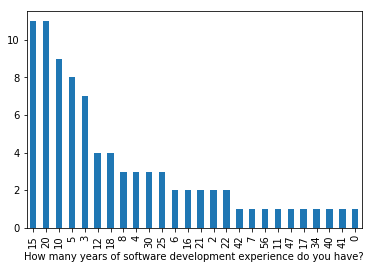

In [129]:
freq_plotting(year_dev, sort_order=True)

In [34]:
# ## 'How many software components from science.canarie.ca have you integrated into your projects?',

software_component = freq_table(df,'How many software components from science.canarie.ca have you integrated into your projects?', add_ratio=True, sort_order=True)
software_component = software_component.rename(lambda x: str(int(x)))


In [35]:
software_component 

col_0,count,ratio
How many software components from science.canarie.ca have you integrated into your projects?,,
3,1,0.013889
4,1,0.013889
6,1,0.013889
12,1,0.013889
50,1,0.013889
2,5,0.069444
1,6,0.083333
0,56,0.777778


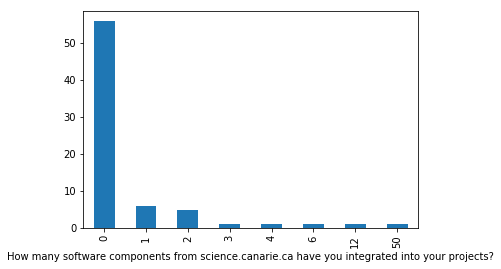

In [128]:
freq_plotting(software_component, sort_order=True)

In [37]:
# ## 'What percentage of these developers are dedicated to the project full time?',

project_full_time = freq_table(df, 'What percentage of these developers are dedicated to the project full time?', add_ratio=True, sort_order=True)
project_full_time = project_full_time.reindex(['0%',
               '25%',
               '50%',
               '75%',
               '100%'
               ])

In [38]:
project_full_time

col_0,count,ratio
What percentage of these developers are dedicated to the project full time?,,
0%,22,0.255814
25%,20,0.232558
50%,16,0.186047
75%,20,0.232558
100%,8,0.093023


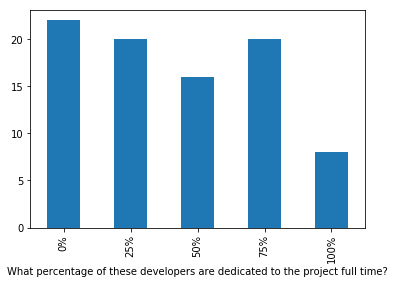

In [39]:
freq_plotting(project_full_time)

In [40]:
var = explore_other('What development methodology does your current project use?')
methodology_values = {'agile': 'Agile',
                      'scrum': 'Scrum',
                      'depends on the project': 'No formal methodology'}
merging_others(df, var, methodology_values)

In [41]:
methodology = freq_table(df, var, add_ratio=True, sort_order=True)

In [42]:
methodology

col_0,count,ratio
What development methodology does your current project use?,,
Other,1,0.011765
Agile,2,0.023529
Waterfall,6,0.070588
Kanban,8,0.094118
Scrum,12,0.141176
No formal methodology,56,0.658824


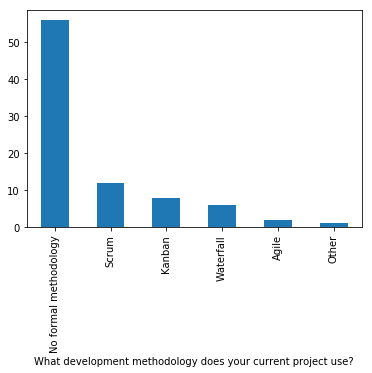

In [127]:
freq_plotting(methodology, sort_order=True)

In [44]:
var = explore_other('What type of organization do you work for?')
merging_others(df, var)
university_work = freq_table(df, var, add_ratio=True, sort_order=True)


In [45]:
university_work

col_0,count,ratio
What type of organization do you work for?,,
Charity,1,0.011236
Other,3,0.033708
College,4,0.044944
Government department,5,0.056180
Private sector,7,0.078652
Non-profit,20,0.224719
University,49,0.550562


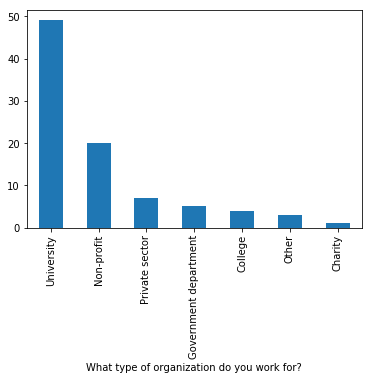

In [46]:
freq_plotting(university_work, sort_order=True)

In [47]:
var = explore_other('In which application area do you primarily work?')
merging_others(df, var, discipline_values)
application_area = freq_table(df, var, add_ratio=True, sort_order=True)

In [48]:
application_area

col_0,count,ratio
In which application area do you primarily work?,,
Fluid mechanics,1,0.011494
Information and communication services,1,0.011494
Robotics,1,0.011494
Polymer chemistry,1,0.011494
Industrial engineering,1,0.011494
Physical geography,1,0.011494
Statistics and probability,1,0.011494
Geophysics,1,0.011494
Physical chemistry,1,0.011494


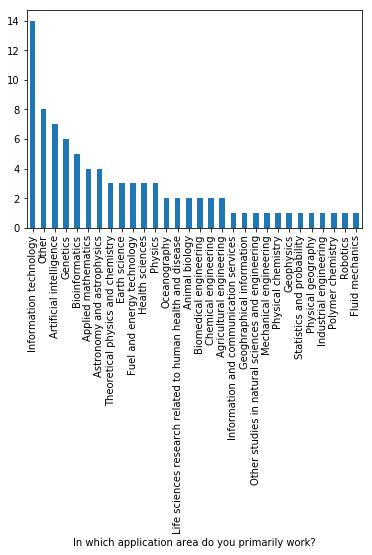

In [49]:
freq_plotting(application_area, sort_order=True)

In [50]:
var = explore_other('What is the nature of your current employment?')
merging_others(df, var)
nature_employment = freq_table(df, var, add_ratio=True, sort_order=True)

In [51]:
nature_employment

col_0,count,ratio
What is the nature of your current employment?,,
Self-employed,1,0.011111
Co-op/intern,2,0.022222
Other,3,0.033333
Grad student,4,0.044444
Part-time,4,0.044444
Contract,7,0.077778
Full-time,69,0.766667


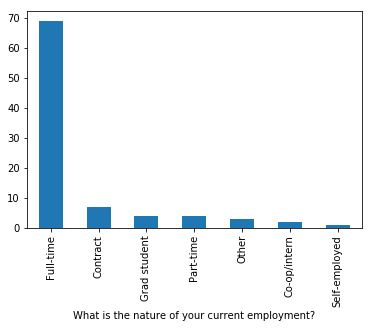

In [52]:
freq_plotting(nature_employment, sort_order=True)

In [53]:
var = explore_other('What is your Operating System of choice for development?')
os_deploy_values = {' ': 'Several OS'}
merging_others(df, var, os_deploy_values)
os_development = freq_table(df, var, add_ratio=True, sort_order=True)

In [54]:
os_development

col_0,count,ratio
What is your Operating System of choice for development?,,
Several os,3,0.035294
Mac os,17,0.200000
Windows,21,0.247059
Gnu/linux,44,0.517647


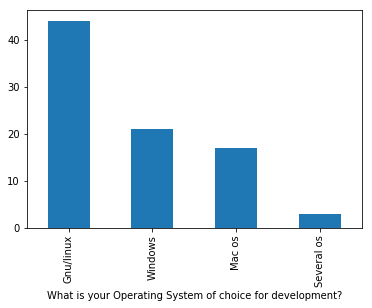

In [55]:
freq_plotting(os_development, sort_order=True)

In [56]:
var = explore_other('What is your Operating System of choice for deployment?')
os_dev_values = {'linux': 'Several OS',
                 'windows': 'Several OS',
                 'mac': 'Several OS'}
merging_others(df, var, os_dev_values)
os_development = freq_table(df, var, add_ratio=True, sort_order=True)

In [57]:
os_development

col_0,count,ratio
What is your Operating System of choice for deployment?,,
Android,1,0.011628
Other,2,0.023256
Ios,3,0.034884
Several os,3,0.034884
Mac os,7,0.081395
Windows,16,0.186047
Gnu/linux,54,0.627907


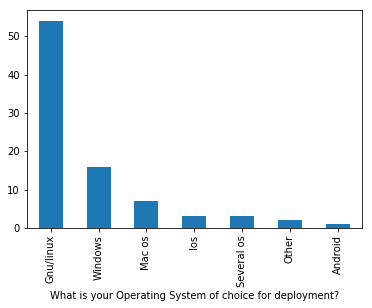

In [58]:
freq_plotting(os_development, sort_order=True)

In [59]:
time_activity = ['On average, how much of your time is spent developing software?',
                 'On average, how much of your time is spent on research?',
                 'On average, how much of the time you spend developing software is spent on new development/enhancement?',
                 'On average, how much of the time you spend developing software is devoted to maintenance and support activities?',
                 'On average, how much time do you spend on management?',
                 'On average, how much time do you spend on other activities?']
recode_time = {'never': '1',
               '5': '5',
               '10': '10'}
for i in time_activity:
    df[i] = df[i].apply(recode_values, args=(recode_time,))


# Calculate the average of all the time_activity questions and plotting them

# Convert the different column to an int value to be able to calculate the mean after
# The option 'coerce' is needed to force passing the NaN values
df[time_activity] = df[time_activity].apply(pd.to_numeric, errors='coerce')
mean_activity = df[time_activity].mean(axis=0)

In [60]:
mean_activity.sort_values()

On average, how much time do you spend on other activities?                                                         2.988506
On average, how much time do you spend on management?                                                               3.337079
On average, how much of the time you spend developing software is devoted to maintenance and support activities?    3.400000
On average, how much of your time is spent on research?                                                             4.438202
On average, how much of your time is spent developing software?                                                     5.077778
On average, how much of the time you spend developing software is spent on new development/enhancement?             5.677778
dtype: float64

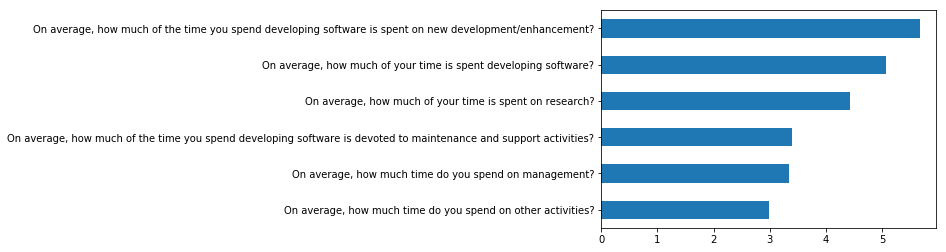

In [61]:
mean_activity.sort_values().plot(kind='barh')

In [62]:
hope = ['What would you hope to get out of such an organization? [Networking]',
        'What would you hope to get out of such an organization? [Software collaborations]',
        'What would you hope to get out of such an organization? [Research collaborations]',
        'What would you hope to get out of such an organization? [Training]',
        'What would you hope to get out of such an organization? [Research Software Standards and Interoperability]',
        'What would you hope to get out of such an organization? [Job opportunities]']

# # The column '[Other]' contain only one 'Colloque?' and is therefore discarded

# Plotting a bar chart
count_hope = count_unique_value(df, hope, rename_columns=True, dropna=True)


In [63]:
count_hope['Yes'].sort_values()

Job opportunities                                   19
Research collaborations                             33
Research Software Standards and Interoperability    34
Training                                            38
Software collaborations                             42
Networking                                          46
Name: Yes, dtype: int64

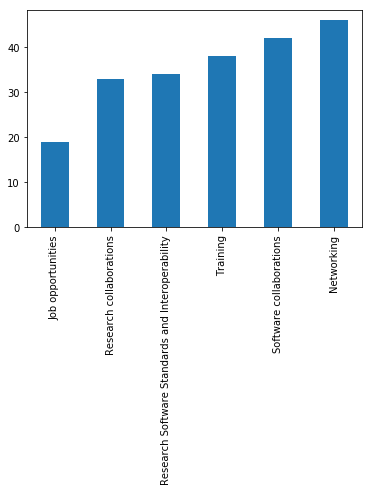

In [64]:
count_hope['Yes'].sort_values().plot(kind='bar')

In [65]:
fund = ["How is your current research software work funded? [Employer]",
        "How is your current research software work funded? [CANARIE]",
        "How is your current research software work funded? [Canadian Foundation for Innovation (CFI)]",
        "How is your current research software work funded? [Canadian Institutes of Health Research (CIHR)]",
        "How is your current research software work funded? [Genome Canada]",
        "How is your current research software work funded? [Natural Sciences and Engineering Research Council of Canada (NSERC)]",
        "How is your current research software work funded? [Social Sciences and Humanities Research Council (SSHRC)]",
        "How is your current research software work funded? [I don't know]"]

# The Others column as the following answers
df["How is your current research software work funded? [Other]"].unique()

# The different funding
count_fund = count_unique_value(df, fund, rename_columns=True)


In [66]:
count_fund['Yes'].sort_values()

Social Sciences and Humanities Research Council (SSHRC)                 3
Genome Canada                                                           8
I don't know                                                            9
Canadian Institutes of Health Research (CIHR)                          10
CANARIE                                                                15
Canadian Foundation for Innovation (CFI)                               18
Natural Sciences and Engineering Research Council of Canada (NSERC)    39
Employer                                                               51
Name: Yes, dtype: int64

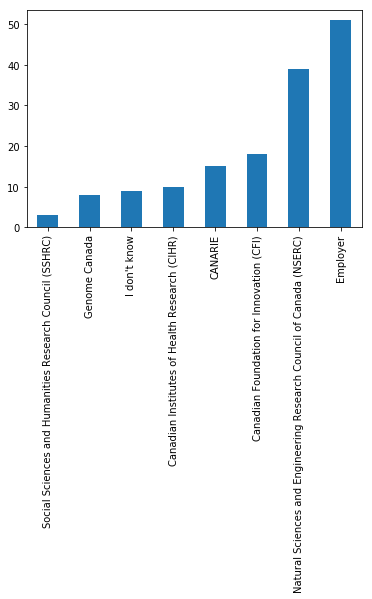

In [67]:
count_fund['Yes'].sort_values().plot(kind='bar')

In [68]:
plateform = ['What platform(s) are your research software projects deployed on? [Compute Canada HPC]',
             'What platform(s) are your research software projects deployed on? [University computer centre]',
             'What platform(s) are your research software projects deployed on? [Other HPC]',
             'What platform(s) are your research software projects deployed on? [Cloud service]',
             'What platform(s) are your research software projects deployed on? [Stand-alone server(s)]',
             'What platform(s) are your research software projects deployed on? [Laptop/desktop]',
             'What platform(s) are your research software projects deployed on? [Mobile]']

# The different values for others:
freq_table(df, "What platform(s) are your research software projects deployed on? [Other]")


count_plateform = count_unique_value(df, plateform, rename_columns=True)




In [69]:
count_plateform['Yes'].sort_values()

Mobile                         8
Cloud service                 19
University computer centre    20
Other HPC                     20
Compute Canada HPC            33
Stand-alone server(s)         45
Laptop/desktop                52
Name: Yes, dtype: int64

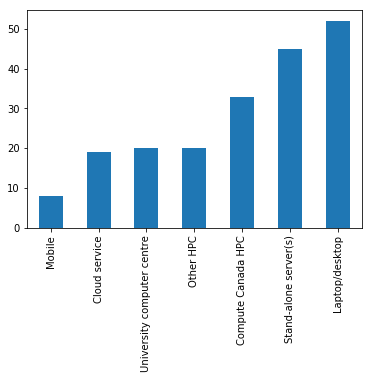

In [70]:
count_plateform['Yes'].sort_values().plot(kind='bar')

In [71]:
testing = ['How are your projects typically tested? [No formal testing]',
           'How are your projects typically tested? [The developers do their own testing]',
           'How are your projects typically tested? [Dedicated test engineers]',
           'How are your projects typically tested? [User testing]']

count_testing = count_unique_value(df, testing, rename_columns=True)


In [72]:
count_testing['Yes'].sort_values()

No formal testing                      10
Dedicated test engineers               11
User testing                           49
The developers do their own testing    81
Name: Yes, dtype: int64

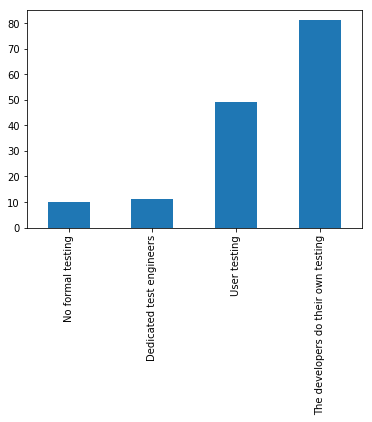

In [73]:
count_testing['Yes'].sort_values().plot(kind='bar')

In [74]:
various_q = ['Do your research software projects typically include a project manager?',
             'Do any of your current projects accommodate the open/public sharing of data?',
             'Is the creation of a Digital Object Identifier (DOI) and metadata for individual assets supported?',
             'Have you developed software that is accessed from multiple institutions?',
             'Do any of your current or previous projects make use of the Canadian Access Federation (CAF) Federated Identity Management (FIM) service?',
             'Have you ever visited the Research Software Registry at science.canarie.ca?',
             'Do you consider yourself a professional software developer?']

count_various_q = count_unique_value(df, various_q, rename_columns=False, dropna=True)


In [75]:
count_various_q['Yes'].sort_values()

Do any of your current or previous projects make use of the Canadian Access Federation (CAF) Federated Identity Management (FIM) service?     5.0
Is the creation of a Digital Object Identifier (DOI) and metadata for individual assets supported?                                           14.0
Have you ever visited the Research Software Registry at science.canarie.ca?                                                                  32.0
Do any of your current projects accommodate the open/public sharing of data?                                                                 36.0
Do your research software projects typically include a project manager?                                                                      41.0
Do you consider yourself a professional software developer?                                                                                  44.0
Have you developed software that is accessed from multiple institutions?                                                    

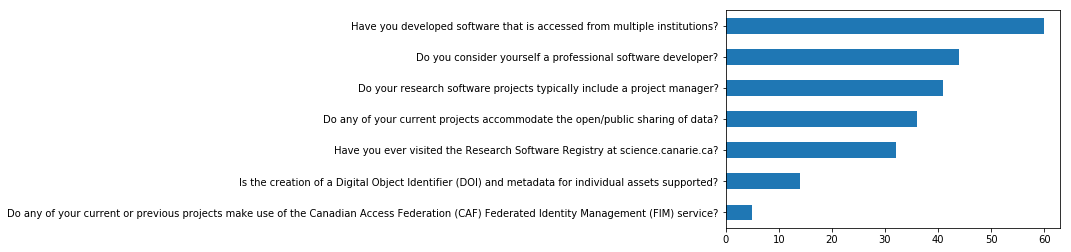

In [100]:
count_various_q['Yes'].sort_values().plot(kind='barh')

In [77]:
organization = ['Do you work within a group that provides software development help or expertise to researchers from across your organization?',
                'Is there such a group within your organization?',
                'Do you think such a group would have value?',
                'Would you be interested in participating in such a group?']

count_orga = count_unique_value(df, organization, dropna=True)


In [78]:
count_orga['Yes'].sort_values()

Is there such a group within your organization?                                                                                   8
Would you be interested in participating in such a group?                                                                        12
Do you think such a group would have value?                                                                                      16
Do you work within a group that provides software development help or expertise to researchers from across your organization?    48
Name: Yes, dtype: int64

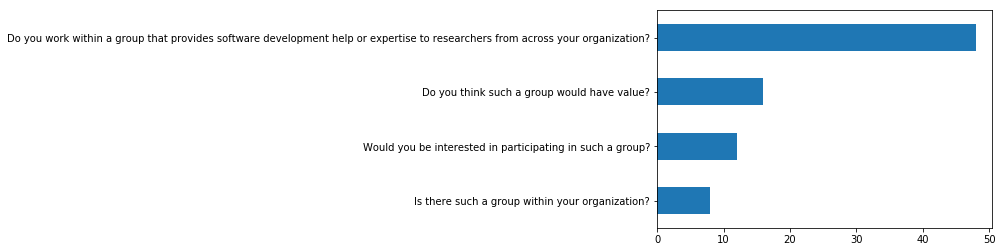

In [79]:
count_orga['Yes'].sort_values().plot(kind='barh')

In [80]:
recognition = ['Have you contributed software to research that has been published in a journal or presented at a conference?',
               'In general, when your software contributes to a paper, are you acknowledged in that paper?',
               'Are you generally named as the main author of the paper?',
               'Are you generally named as a co-author of the paper?',
               'Are you generally acknowledged in the main paper?']

count_recognition = count_unique_value(df, recognition, dropna=True)


In [81]:
count_recognition['Yes'].sort_values()

Are you generally named as the main author of the paper?                                                        24
Are you generally acknowledged in the main paper?                                                               43
Are you generally named as a co-author of the paper?                                                            45
In general, when your software contributes to a paper, are you acknowledged in that paper?                      60
Have you contributed software to research that has been published in a journal or presented at a conference?    70
Name: Yes, dtype: int64

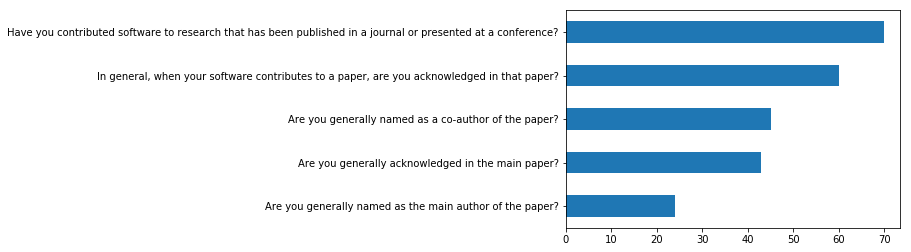

In [82]:
count_recognition['Yes'].sort_values().plot(kind='barh')

In [83]:
rse_canada = ['Are you a member of an association of Research Software Developers (e.g UK RSE)?',
              'Would you be interested in joining such an organization if one was formed in Canada?']
count_rse_canada = count_unique_value(df, rse_canada, dropna=True)
count_rse_canada

,No,Yes
Are you a member of an association of Research Software Developers (e.g UK RSE)?,85,3
Would you be interested in joining such an organization if one was formed in Canada?,20,59


In [84]:
count_rse_canada['Yes']

Are you a member of an association of Research Software Developers (e.g UK RSE)?         3
Would you be interested in joining such an organization if one was formed in Canada?    59
Name: Yes, dtype: int64

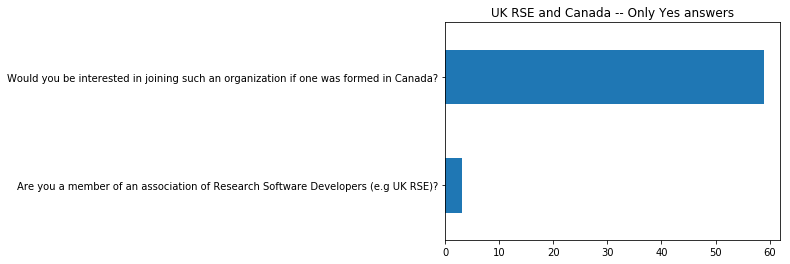

In [85]:
count_rse_canada['Yes'].plot(kind='barh', title='UK RSE and Canada -- Only Yes answers')


In [156]:
conference_YN = 'Have you ever presented your software work at a conference or workshop?'
count_conference = freq_table(df, conference_YN, add_ratio=True, sort_order=True)

In [157]:
count_conference

col_0,count,ratio
Have you ever presented your software work at a conference or workshop?,,
No,33,0.4125
Yes,47,0.5875


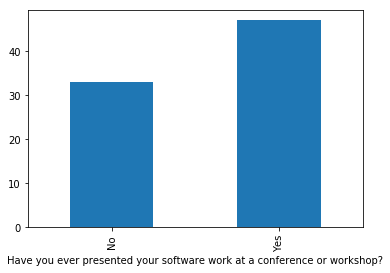

In [163]:
freq_plotting(count_conference)

In [167]:
#conference_list = 'Which conference(s)/workshop(s)?'
#freq_table(df, conference_list, sort_order=True)

,count
Which conference(s)/workshop(s)?,
"1. A. Kosakian, M. Secanell, D. Novitski, and S. Holdcroft, “Numerical estimation of oxygen transport properties in thin polymer membranes.” Proceedings of the Canadian Society for Mechanical Engineering International Congress, Kelowna, BC, Canada, June 26-29, 2016\n2. A. Kosakian, M. Secanell, D. Novitski, and S. Holdcroft, “A numerical algorithm for estimation of oxygen transport properties in thin polymer membranes.” 5th Annual CaRPE-FC Technical Review Meeting, Vancouver, BC, Canada, May 2-3, 2016 (talk and poster)",1
High Performance Computing Symposium,1
Human Brain Mapping\nBrainhack\nHPCS,1
"ICDCS, IPCCC, MASCOTS, IWQoS, LCN, ACM Multimedia",1
"IEEE ICCI*CC 2016\nSAM, WorldComp 2016",1
In previous position at ESRI User's Conference & Developer's Summit and at company user's conference.,1
"It was years ago, as a student working for a professor who was working on a model to statistically sample coal composition. (to predict usage based on that composition). He took me & the software to a conference to show it off. Since then, no.",1
Many - the software is often part of the research project,1
HPCS,1


In [164]:
open_code_YN = ['When you release code, how often do you use an open source license?',
                'When you release code or data, how often do you assign a Digital Object Identifier (DOI) to it?']


count_open = count_unique_value(df, open_code_YN, dropna=True)

In [165]:
count_open

,1 (Never),2,3,4,5 (Always)
"When you release code, how often do you use an open source license?",11,13,4,14,41
"When you release code or data, how often do you assign a Digital Object Identifier (DOI) to it?",58,8,5,5,4


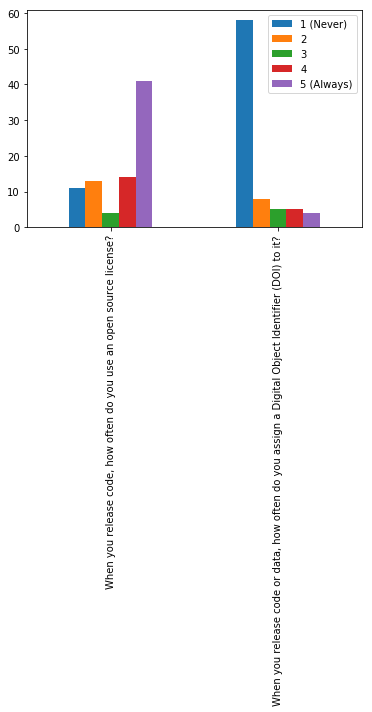

In [166]:
count_open.plot(kind='bar')

In [117]:
open_code_list = 'List any open repositories (eg. GitHub) to which your software projects have been published.'

In [92]:
data_management = ['Do any of your current projects make use of a data management or data archiving component?',
                   'Is it part of your software or an external system? (please specify)']

count_data_management = count_unique_value(df, data_management, dropna=True)


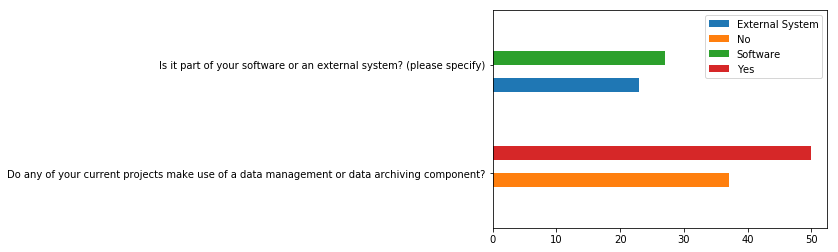

In [93]:
count_data_management.plot(kind='barh')

In [94]:
# ## 'What is your current job title?',

pd.crosstab(df['What is your current job title?'].str.capitalize(), colnames=[''], columns='Job title')

,Job title
What is your current job title?,
Analyste informatique,1
Applicants analyst,1
Assistant director of data management,1
Assistant professor,2
Associate professor,5
Associate researcher,1
Associé de recherche,1
Asst prof,1
Bioinformatics programmer,1


In [95]:
# ## 'In your opinion, what are the three most important skills that a Research Software Developer must possess? These skills can be technical and non-technical.',

In [96]:
# ## 'What three skills would you like to acquire or improve to help your work as a Research Software Developer? These skills can be technical and non-technical.',

In [97]:
# ## 'What are the three tools or services you use most often in your software work?',

In [98]:
# ## 'What programming languages do you use in developing research software? Please list in order, beginning with most frequently used.',

In [99]:
# ## 'List any public identity providers (e.g. Google, Facebook, Live, LinkedIn, Twitter, etc.) used in your current or previous projects.',